# Exercise 5.30 from Boyd

5.30 Derive the KKT conditions for the problem
$$\begin{array}{ll}\text { minimize } & \operatorname{tr} X-\log \operatorname{det} X \\ \text { subject to } & X s=y\end{array}$$
with variable $X \in \mathbf{S}^n$ and domain $\mathbf{S}_{++\cdot}^n y \in \mathbf{R}^n$ and $s \in \mathbf{R}^n$ are given, with $s^T y=1$. Verify that the optimal solution is given by
$$
X^{\star}=I+y y^T-\frac{1}{s^T s} s s^T .
$$

In [15]:
import os
import copy

import numpy as np
import matplotlib.pyplot as plt

import torch
import cooper

from copy import deepcopy
from typing import Tuple

In [2]:
class BoydsProblem(cooper.ConstrainedMinimizationProblem):
    def __init__(self, s: torch.tensor, y: torch.tensor):
        self.s = s
        self.y = y
        super().__init__(is_constrained=True)

    def closure(self, L):
        Lt = torch.transpose(L, 0, 1)
        loss = torch.trace(torch.matmul(L, Lt)) - torch.logdet(torch.matmul(L, Lt))

        eq_defect = torch.matmul(torch.matmul(L, Lt), self.s) - self.y

        return cooper.CMPState(
            loss=loss, eq_defect=eq_defect
        )

In [26]:
def problem_formulation(
    s: torch.Tensor, 
    y: torch.Tensor, 
    learning_rate_primal_optimizer: float, 
    learning_rate_dual_optimizer: float
    )->Tuple[
        BoydsProblem, 
        cooper.lagrangian_formulation.LagrangianFormulation, 
        torch.nn.parameter.Parameter,
        cooper.constrained_optimizer.ConstrainedOptimizer,
        cooper.constrained_optimizer.ConstrainedOptimizer,
        cooper.constrained_optimizer.ConstrainedOptimizer,
        cooper.state_logger.StateLogger
        ]:
    """
    Formulate the problem.
    """
    cmp = BoydsProblem(s, y)
    formulation = cooper.LagrangianFormulation(cmp)
    
    L = torch.nn.Parameter(torch.rand(s.size()[0],s.size()[0]))

    primal_optimizer = torch.optim.SGD([L], lr=learning_rate_primal_optimizer)
    dual_optimizer = cooper.optim.partial_optimizer(
        torch.optim.SGD, lr= learning_rate_dual_optimizer
        )

    coop = cooper.ConstrainedOptimizer(
        formulation=formulation,
        primal_optimizer=primal_optimizer,
        dual_optimizer=dual_optimizer,
    )
    state_history = cooper.StateLogger(save_metrics=["loss", "eq_defect", "eq_multipliers"])
    return cmp, formulation, L, primal_optimizer, dual_optimizer, coop, state_history

In [27]:
def train_problem(
    cmp: BoydsProblem, 
    formulation: cooper.lagrangian_formulation.LagrangianFormulation, 
    L: torch.nn.parameter.Parameter, 
    primal_optimizer: cooper.constrained_optimizer.ConstrainedOptimizer, 
    dual_optimizer: cooper.constrained_optimizer.ConstrainedOptimizer, 
    coop: cooper.constrained_optimizer.ConstrainedOptimizer, 
    state_history: cooper.state_logger.StateLogger, 
    iterations: int = 1000, 
    wandb_log: bool = False
    )->Tuple[torch.nn.parameter.Parameter, cooper.state_logger.StateLogger]:

    for iter_num in range(iterations):

        coop.zero_grad()
        lagrangian = formulation.composite_objective(cmp.closure, L)
        formulation.custom_backward(lagrangian)
        coop.step(cmp.closure, L)

        # Store optimization metrics at each step
        partial_dict = {"params": copy.deepcopy(L)}
        state_history.store_metrics(formulation, iter_num, partial_dict)
        aux = deepcopy(formulation.cmp.state.eq_defect.data)
    if wandb_log:
        log_metrics(formulation, iter_num)
    return L, state_history

In [42]:
def plot_metrics(state_history):
    all_metrics = state_history.unpack_stored_metrics()
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, sharex=True, figsize=(15, 3))

    ax0.plot(all_metrics["iters"], np.stack(all_metrics["eq_multipliers"]))
    ax0.set_title("Multipliers")
    
    ax1.plot(all_metrics["iters"], np.stack(all_metrics["eq_defect"]), alpha=0.6)
    ax1.axhline(0.0, c="gray", alpha=0.2)
    ax1.set_title("Defects")

    ax2.plot(all_metrics["iters"], all_metrics["loss"])
    ax2.set_title("Objective")

    [_.semilogx() for _ in (ax0, ax1, ax2)]
    plt.show()

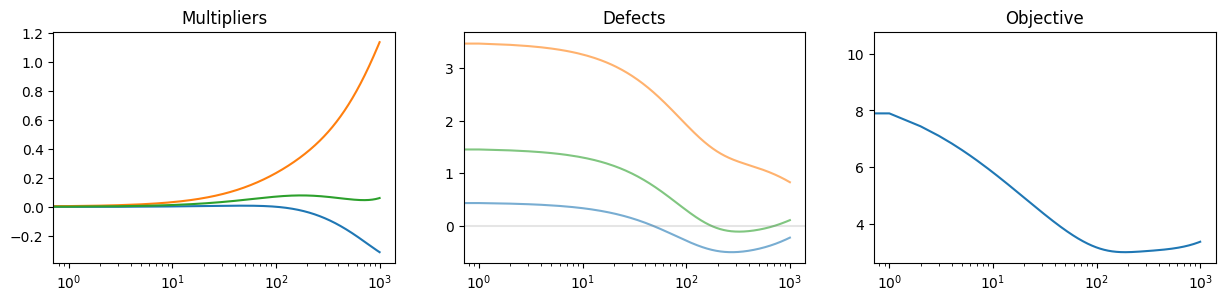

In [44]:
s = torch.Tensor([0.5, 0.5, 1])
y = torch.Tensor( [1, -1, 1])
assert type(s) == torch.Tensor
assert type(y) == torch.Tensor
assert torch.matmul(s.T ,y) == 1
cmp, formulation, L, primal_optimizer, dual_optimizer, coop, state_history = problem_formulation(s, y, 3e-3, 9e-4)
L, state_history = train_problem(cmp, formulation, L, primal_optimizer, dual_optimizer, coop, state_history , 1000)
plot_metrics(state_history)

### Experiments with wandb

In [30]:
import wandb
import os
wandb.login()
os.environ['WANDB_NOTEBOOK_NAME'] = 'Example 5.30'

In [9]:
config = dict(
    iterations=1000,
    learning_rate_primal_optimizer=3e-3,
    learning_rate_dual_optimizer=9e-4,
    s = [0.5, 0.5, 1],
    y = [1, -1, 1]
    )

In [86]:
def log_metrics(formulation, step):
    multipliers =  deepcopy(formulation.state()[1].data)
    multipliers = multipliers.numpy()
    # Save multipliers on dictionary
    #wandb.log({"multipliers": wandb.Plotly(multipliers)}, step=step)
    wandb.log({
          "Multiplier 1": multipliers[0], 
          "Multiplier 2": multipliers[1],
          "Multiplier 3": multipliers[2], 
          "Defect 1": deepcopy(formulation.cmp.state.eq_defect.data)[0],
          "Defect 2": deepcopy(formulation.cmp.state.eq_defect.data)[1],
          "Defect 3": deepcopy(formulation.cmp.state.eq_defect.data)[2],
          "loss":  formulation.cmp.state.loss.item()}, 
          step = step)

In [85]:
def log_plots(state_history):
    all_metrics = state_history.unpack_stored_metrics()
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, sharex=True, figsize=(15, 3))

    ax0.plot(all_metrics["iters"], np.stack(all_metrics["eq_multipliers"]))
    ax0.set_title("Multipliers")
    
    ax1.plot(all_metrics["iters"], np.stack(all_metrics["eq_defect"]), alpha=0.6)
    ax1.axhline(0.0, c="gray", alpha=0.2)
    ax1.set_title("Defects")

    ax2.plot(all_metrics["iters"], all_metrics["loss"])
    ax2.set_title("Objective")

    [_.semilogx() for _ in (ax0, ax1, ax2)]
    wandb.log({"plots": wandb.Image(fig)})

In [89]:
def solution_pipeline(project_name: str, hyperparameters: dict):
  # tell wandb to get started
  with wandb.init(project = project_name, config = hyperparameters ):
    # access all HPs through wandb.config, so logging matches execution!
    config = wandb.config

    s = torch.Tensor(config["s"])
    y = torch.Tensor(config["y"])
    assert type(s) == torch.Tensor
    assert type(y) == torch.Tensor
    assert torch.matmul(s.T ,y) == 1
    
    cmp, formulation, L, primal_optimizer, dual_optimizer, coop, state_history = problem_formulation(s, y, config["learning_rate_primal_optimizer"], config["learning_rate_dual_optimizer"])
    L, state_history = train_problem(cmp, formulation, L, primal_optimizer, dual_optimizer, coop, state_history , config["iterations"], wandb_log = True)
    log_plots(state_history)
  return L, state_history

In [91]:
L, state_history = solution_pipeline(project_name = "Example 5.30", hyperparameters = config)
plot_metrics(state_history)